In [1]:
import sqlite3
import pandas as pd
import seaborn as sns

In [2]:
conn = sqlite3.connect('/Users/aaronlevi/Documents/sql_db/chords_list.db')
cur = conn.cursor()

In [3]:
allFeatures = pd.read_sql_query("SELECT * FROM features", conn)
labels = pd.read_sql_query("SELECT label FROM basic_info", conn)

allFeatures = allFeatures.iloc[57:1329].reset_index(drop=True)
allFeatures.drop('index', axis=1, inplace=True)

labels = labels.iloc[57:1329].reset_index(drop=True)

In [4]:
dummyLabel=pd.get_dummies(labels)
dummyLabel.head()

,Label_advanced,Label_intermediate,Label_novice
0,0,0,1
1,1,0,0
2,1,0,0
3,0,1,0
4,0,1,0


In [5]:
# making a few df's for ease of plotting... kinda clunky
featuresWithLabels = pd.concat([allFeatures, dummyLabel], axis=1, sort=False)
featuresWithLabels.dropna(axis=0, how='any', inplace=True)

featuresNovice = pd.concat([allFeatures, dummyLabel['Label_novice']], axis=1, sort=False)
featuresNovice.dropna(axis=0, how='any', inplace=True)

featuresAdv = pd.concat([allFeatures, dummyLabel['Label_advanced']], axis=1, sort=False)
featuresAdv.dropna(axis=0, how='any', inplace=True)
featuresAdv.head()

,tempo,duration_m,time_signature,energy,n_unique_chords,n_difficult_chords,chord_per_min,Label_advanced
0,172.286,3.533967,4.0,0.292,3,0,0.848904,0
1,96.996,1.981967,4.0,0.771,12,12,6.054592,1
2,75.646,5.499333,4.0,0.223,5,1,0.909201,1
3,120.042,3.588000,4.0,0.762,6,4,1.672241,0
4,150.190,5.052000,4.0,0.558,8,4,1.583531,0


In [6]:
small_adv = featuresAdv[featuresAdv['Label_advanced']==1]['n_unique_chords']<=3 
small_adv_ix = [i for i, x in enumerate(small_adv) if x]
sum(small_adv)

19

In [7]:
# advanced label
advX = featuresAdv.drop(featuresAdv.index[small_adv_ix])
advX.dropna(axis=0, how='any', inplace=True)
advX.reset_index(drop=True)

advy = advX['Label_advanced']
advX.drop('Label_advanced', axis=1, inplace=True)

In [90]:
outliers = featuresAdv['n_unique_chords']>=55 
outlier_ix = [i for i, x in enumerate(small_adv) if x]

# advanced label
advX = featuresAdv.drop(featuresAdv.index[outlier_ix])
advX.dropna(axis=0, how='any', inplace=True)
advX.reset_index(drop=True)

advy = advX['Label_advanced']
advX.drop('Label_advanced', axis=1, inplace=True)

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(advX)
advX_scale = scaler.transform(advX)

advX_train, advX_test, advy_train, advy_test = train_test_split(advX_scale, advy, test_size=0.2, random_state=10)

lr_model_adv = LogisticRegression()
lr_model_adv.fit(advX_train, advy_train) 

LogisticRegression()

In [92]:
adv_predictions = lr_model_adv.predict(advX_test)
adv_true = advy_test

In [93]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(advy_test, adv_predictions))
print(classification_report(advy_test, adv_predictions))

[[159  12]
 [ 36  44]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       171
           1       0.79      0.55      0.65        80

    accuracy                           0.81       251
   macro avg       0.80      0.74      0.76       251
weighted avg       0.81      0.81      0.80       251



In [15]:
pd.DataFrame(lr_model_adv.coef_, columns=advX.columns)

,tempo,duration_m,time_signature,energy,n_unique_chords,n_difficult_chords,chord_per_min
0,-0.056784,0.302553,-0.10113,0.138869,0.22024,1.792578,0.540012


In [23]:
# NOVICE label
novX = featuresNovice.drop(featuresNovice.index[small_adv_ix])
novX.dropna(axis=0, how='any', inplace=True)
novX.reset_index(drop=True)

novy = novX['Label_novice']
novX.drop('Label_novice', axis=1, inplace=True)


In [24]:
scaler = StandardScaler()

scaler.fit(novX)
novX_scale = scaler.transform(novX)

novX_train, novX_test, novy_train, novy_test = train_test_split(novX_scale, novy, test_size=0.2, random_state=10)

lr_model_nov = LogisticRegression()
lr_model_nov.fit(novX_train, novy_train) 

LogisticRegression()

In [26]:
nov_predictions = lr_model_nov.predict(novX_test)
nov_true = novy_test

print(confusion_matrix(novy_test, nov_predictions))
print(classification_report(novy_test, nov_predictions))

[[140  22]
 [ 56  33]]
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       162
           1       0.60      0.37      0.46        89

    accuracy                           0.69       251
   macro avg       0.66      0.62      0.62       251
weighted avg       0.67      0.69      0.67       251



In [31]:
adv_splitIx=advy_test.index.tolist()
nov_splitIx=novy_test.index.tolist()

print(adv_splitIx)
print(nov_splitIx)

[903, 958, 1206, 439, 852, 435, 152, 340, 74, 586, 245, 436, 132, 1112, 588, 1111, 638, 1024, 1271, 745, 1128, 348, 198, 502, 687, 372, 514, 189, 540, 432, 1088, 471, 376, 201, 1135, 537, 1068, 1139, 12, 873, 971, 154, 46, 1227, 735, 318, 1043, 791, 1226, 556, 770, 1119, 1236, 382, 1035, 229, 34, 1136, 1098, 429, 486, 7, 1239, 402, 808, 885, 617, 111, 312, 1092, 615, 1008, 38, 965, 505, 416, 1170, 748, 1245, 339, 464, 94, 511, 889, 388, 337, 460, 233, 923, 1073, 1006, 133, 1222, 685, 81, 151, 1173, 1071, 750, 394, 520, 888, 148, 444, 332, 1001, 1079, 1219, 482, 129, 819, 430, 574, 592, 1177, 1105, 239, 510, 70, 287, 447, 977, 236, 636, 462, 962, 279, 241, 728, 76, 954, 32, 228, 722, 523, 1042, 876, 739, 286, 1101, 1014, 644, 30, 135, 926, 140, 397, 969, 1160, 692, 356, 599, 527, 828, 539, 66, 529, 213, 1089, 121, 400, 742, 113, 291, 821, 655, 255, 949, 273, 184, 573, 795, 1232, 54, 1229, 676, 1216, 389, 25, 378, 130, 530, 1115, 836, 1248, 134, 1198, 737, 62, 160, 1023, 526, 42, 284, 12

In [36]:
adv_probs=lr_model_adv.predict_proba(advX_test)
nov_probs=lr_model_nov.predict_proba(novX_test)

(-0.05, 1.05)

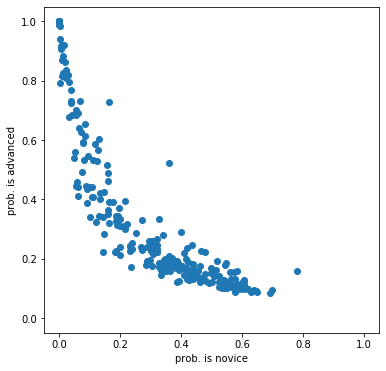

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(6,6))

ax.scatter(nov_probs[:,1], adv_probs[:,1])
ax.set_xlabel('prob. is novice')
ax.set_xlim(-0.05,1.05)
ax.set_ylabel('prob. is advanced')
ax.set_ylim(-0.05,1.05)


In [66]:
splitLabels = labels.loc[nov_splitIx]
splitLabels.head()

,Label
903,novice
958,advanced
1206,novice
439,advanced
852,intermediate


In [67]:
# splitLabels.reset_index(drop=True)

# intLabel = []
# for i in range(0, len(splitLabels)):
#     if splitLabels.iloc[i]['Label'] is 'novice':
#         intLabel[i].append(0)
#     elif splitLabels.iloc[i]['Label'] is 'intermediate':
#         intLabel[i].append1
#     else:
#         intLabel[i].append2

intLabel = pd.factorize(splitLabels['Label'])


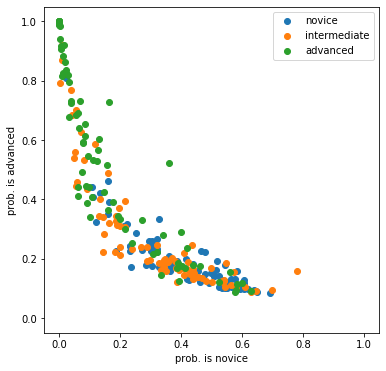

In [79]:
fig,ax = plt.subplots(figsize=(6,6))

ax.scatter(nov_probs[intLabel[0]==0,1], adv_probs[intLabel[0]==0,1])
ax.scatter(nov_probs[intLabel[0]==2,1], adv_probs[intLabel[0]==2,1])
ax.scatter(nov_probs[intLabel[0]==1,1], adv_probs[intLabel[0]==1,1])

ax.set_xlabel('prob. is novice')
ax.set_xlim(-0.05,1.05)
ax.set_ylabel('prob. is advanced')
ax.set_ylim(-0.05,1.05)

ax.legend(['novice', 'intermediate', 'advanced'])

In [84]:
# from sklearn.tree import DecisionTreeClassifier
# dtree = DecisionTreeClassifier()
# dtree.fit([nov_probs, adv_probs], intLabel)

mul_lr = LogisticRegression( 
              multi_class='multinomial', 
              solver='newton-cg', 
              fit_intercept=True 
              )
mul_lr.fit([nov_probs, adv_probs], intLabel)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [88]:
novX['prob_adv'] = adv_probs
novX['prob_nov'] = nov_probs

ValueError: Length of values does not match length of index